In [1]:
import random
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx 
import pylab

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K

Using TensorFlow backend.


In [2]:
"""
This class generates a sequence of physical states
as well as sequence of corresponding physical laws from graph.
dataset_size = number of sequences it generates,
num_states = number of physical states,
max_sequence_size is upper limit to generated sequence length,
connection = logarithmic percentile, which gives the density of laws/state
             using normal distribution.
"""

class GraphLanguage:
    def __init__(self, dataset_size, num_states, max_sequence_size, connection):
        self.dataset_size = dataset_size
        self.max_sequence_size = max_sequence_size
        self.num_states = num_states
        self.connection = connection
    def generate_graph(self):
        G = nx.DiGraph()
        H = range(1,self.num_states+1)
        G.add_nodes_from(H)
        list_of_edges =[]
        edge_labels = {}
        for i in range(1, self.num_states):
            for j in range(1, self.num_states+1):
                d = np.random.randn()
                if d < self.connection and i != j:
                    e = (i,j)
                    list_of_edges.append(e)
                    edge_labels[e] = str(i)+'e'+str(j)
        G.add_edges_from(list_of_edges)
        # connection  = -1.25
        nx.draw(G,pos = nx.spring_layout(G), with_labels=True) 
        pylab.show()
  
        sample_events = []
        sample_relations = []
        sample = []
        target_events = []
        target_events_inputs = []
        target_texts = []
        target_texts_inputs = []
        for _ in range(self.dataset_size):
            sequence_list = []
            sample_rel = []
            #sequence_size = random.randint(1, self.max_sequence_size)
            sequence_size = self.max_sequence_size
            l_descendants = []
            target_event_input = []
            target_event = []
            node = random.randint(1, self.num_states)
            l_descendants.append(node)
            successors = G.successors(node)
            l_successors = list(successors)
            while l_successors and (len(l_descendants) <= sequence_size): 
                successor = random.choice(l_successors)
                node = successor
                l_descendants.append(node)
                successors = G.successors(node)
                l_successors = list(successors)
                str_descendants = [str(item) for item in l_descendants]
                #sequence_list.append(l_descendants)
            for j in range(len(str_descendants)-1):
                rel_list = str_descendants[j]+'s'+str_descendants[j+1]
                sample_rel.append(rel_list)
            a = '<sos>'
            b = '<eos>'
            sample_relations.append(sample_rel)
            sample_events.append(str_descendants)
            
            target_event_input = str_descendants
            target_event = str_descendants
            
            target_event_input = [a] + target_event_input 
            target_event = target_event + [b]
            
            target_events.append(target_event)
            target_events_inputs.append(target_event_input)
            
            sample.append((str_descendants, sample_rel))
            
            target_text = sample_rel
            target_text_input = sample_rel
            
            target_text_input = [a] + target_text_input
            target_text = target_text + [b]
            
            target_texts.append(target_text)
            target_texts_inputs.append(target_text_input)
        return sample, sample_events, sample_relations, target_events, target_events_inputs, target_texts, target_texts_inputs

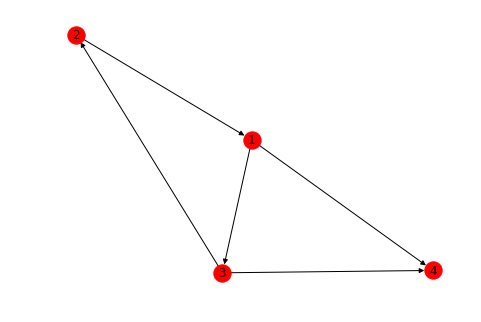

In [3]:
graph = GraphLanguage(100000, 4, 10, 0.3)
sample, sample_events, sample_relations,target_events, target_events_inputs, target_texts, target_texts_inputs = graph.generate_graph()

In [4]:
#print(sample_events)
#print(sample_relations)
#print(sample)
#print(target_texts)
#print(target_texts_inputs)
#print(target_events)
#print(target_events_inputs)

In [5]:
# Creating Word2Vec-like embeddings for states and laws
emb_model1 = Word2Vec(sample_events, size = 10, workers = 2,  sg = 1, min_count=50)
emb_model2 = Word2Vec(sample_relations, size = 10, workers = 2,  sg = 1, min_count = 50)
probes = np.concatenate([sample_events, sample_relations])
#random.shuffle(probes)
emb_model5 = Word2Vec(probes, size = 10, workers = 2, sg = 1, min_count = 50)
emb_model = Word2Vec(sample_events + sample_relations, workers = 2, window = 10,  sg = 1, min_count=50) 

In [6]:
words1 = list(emb_model1.wv.vocab)
words2 = list(emb_model2.wv.vocab)
words5 = list(emb_model5.wv.vocab)
words = list(emb_model.wv.vocab)

In [7]:
# Reducing the number of laws for the orthogonal Procrustes, since X, and Y need to be of the same shape.
n = len(words1)
import collections
word2word_num = {}
for sequence in sample_relations:
    for word in sequence:
        if word not in word2word_num:
            word2word_num[word] = 0 
        word2word_num[word] += 1
word_counter = collections.Counter(word2word_num)
most_common_words = []
common_words = word_counter.most_common(n)
most_common_words = [words for words, counts in common_words]

state2vec1 = {}
for s in words1:
    state2vec1[s] = emb_model1.wv.__getitem__(s)
state2vec2 = {}
for s in words2:
    state2vec2[s] = emb_model2.wv.__getitem__(s)
word2vec = {}
for s in words:
    word2vec[s] = emb_model.wv.__getitem__(s)

In [8]:
X1 = emb_model1.wv.__getitem__(emb_model1.wv.vocab) # Vectors for physical states
X2 = emb_model2.wv.__getitem__(emb_model2.wv.vocab) # Vectors for physical laws
X5 = emb_model5.wv.__getitem__(emb_model5.wv.vocab) # Vectors for both states and laws

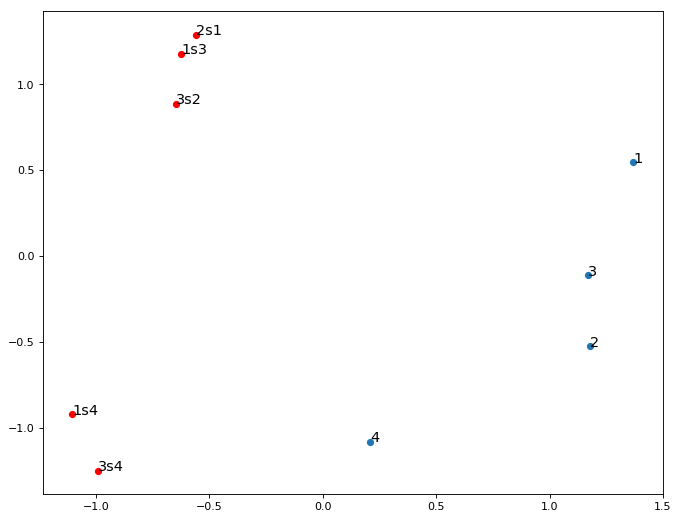

In [9]:
"""
Embedding of states and laws put together, after PCA.
"""
X = emb_model.wv.__getitem__(emb_model.wv.vocab)
pca = PCA(n_components=2, whiten = True)
result = pca.fit_transform(X)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result[:n, 0], result[:n, 1], s= 30)
plt.scatter(result[n:, 0], result[n:, 1],c = 'r', s= 30)
words = list(emb_model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), size = 13)
plt.show()

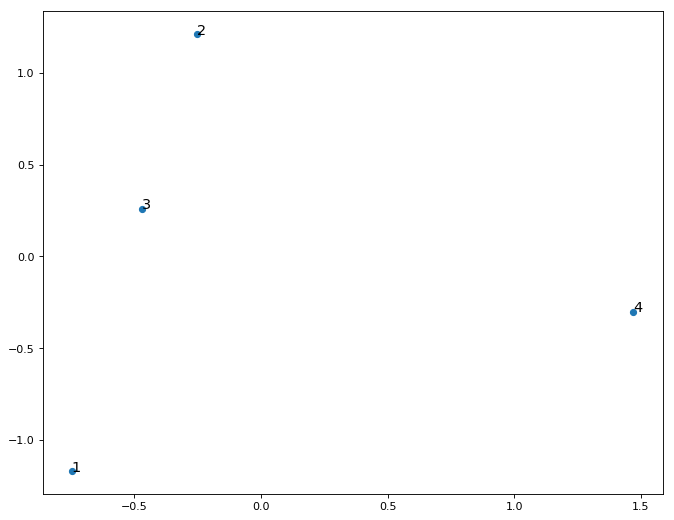

In [10]:
"""
Embedding of states after PCA.
"""
X1 = emb_model1.wv.__getitem__(emb_model1.wv.vocab)
pca = PCA(n_components=2, whiten = True)
result1 = pca.fit_transform(X1)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result1[:n, 0], result1[:n, 1], s = 30)
plt.scatter(result1[n:, 0], result1[n:, 1],c = 'r', s = 30)
words1 = list(emb_model1.wv.vocab)
for i, word in enumerate(words1):
    plt.annotate(word, xy=(result1[i, 0], result1[i, 1]), size = 13)
plt.show()

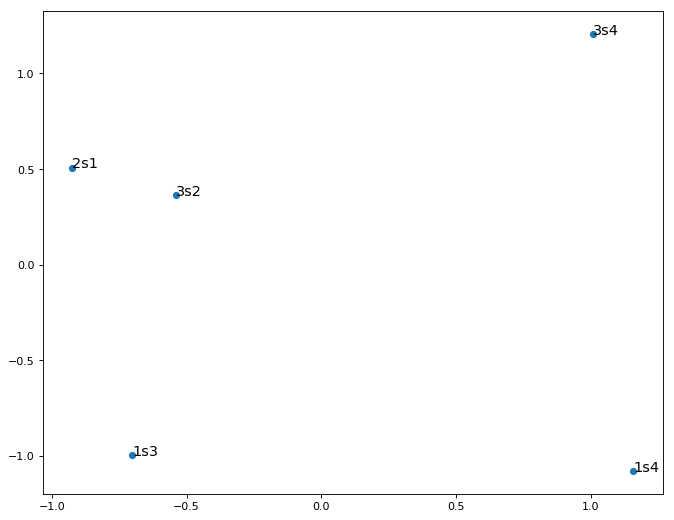

In [11]:
"""
Embedding of laws after PCA.
"""
X2 = emb_model2.wv.__getitem__(emb_model2.wv.vocab)
pca = PCA(n_components=2, whiten = True)
result2 = pca.fit_transform(X2)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result2[:, 0], result2[:, 1], s = 30)
words2 = list(emb_model2.wv.vocab)
for i, word in enumerate(words2):
    plt.annotate(word, xy=(result2[i, 0], result2[i, 1]), size = 13)
plt.show()

In [12]:
state2vec3 = {}
for s in most_common_words:
    state2vec3[s] = state2vec2[s]
X3 = [vec for word, vec in state2vec3.items()]
X3 = np.asarray(X3)
print(X3.shape)
print(X1.shape)
state2vec3 # Most common laws.

(4, 10)
(4, 10)


{'2s1': array([ 0.3417588 ,  0.16597944,  0.83960736,  0.65181404, -0.05753197,
        -0.49583477,  0.31997806, -0.23215632, -0.55782   ,  0.24770494],
       dtype=float32),
 '1s4': array([ 1.4454873 , -0.31747055,  0.35870558,  0.440276  ,  1.0557749 ,
        -0.30861655,  0.18770552,  1.2214966 ,  0.59563017,  0.5168215 ],
       dtype=float32),
 '1s3': array([ 0.23254786,  0.08861652,  0.46168342,  0.33434054,  0.2802484 ,
        -0.09581506,  0.8368359 ,  0.23701736,  0.34481853,  0.67925835],
       dtype=float32),
 '3s2': array([ 0.4270298 ,  0.7702313 ,  0.6312396 , -0.43438748,  0.05834957,
        -0.49340764,  0.1278122 ,  0.22135559,  0.24573207,  0.2852761 ],
       dtype=float32)}

In [13]:
# Orthogonal Procrustes optimization.
from scipy.linalg import orthogonal_procrustes
R, sca = orthogonal_procrustes(X3, X1)
X4 = X3.dot(R) # Orthogonal Procrustes on Restricted Y (tilde Y).
X5 = X2.dot(R) # Orthogonal Procrustes on whole Y.

In [14]:
state2vec5 = {}
state2vec5 = state2vec2
for i, j in enumerate(state2vec5):
    state2vec5[j] = X5[i,:]
# Dictionary for Upsilon law2vec after orthogonal Procrustes.

In [15]:
state2vec6 = {**state2vec1, **state2vec5}
# This dictionary comprises vectors X and Upsilon.

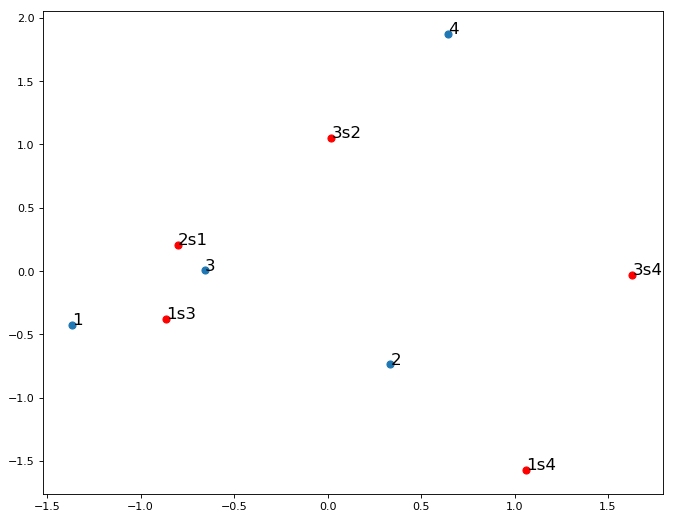

In [16]:
X6 = [vec for word, vec in state2vec6.items()]
pca = PCA(n_components=2, whiten = True)
result6 = pca.fit_transform(np.array(X6))
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result6[:n, 0], result6[:n, 1], s = 40)
plt.scatter(result6[n:, 0], result6[n:, 1], c = 'r', s = 40)
words6 = [word for word, vec in state2vec6.items()] 
for i, word in enumerate(words6):
    plt.annotate(word, xy=(result6[i, 0], result6[i, 1]), size = 15)
plt.show()

In [17]:
#state2vec6 # This dictionary correspond to both vectors X and Upsilon

In [18]:
def state_dist(state1, state2):
    """
    This function lists the distance of the middle point between two states:
    state1 and state2 to all the states from X and Upsilon vectors.
    The output is the corresponding dictionary.
    """
    state2dist = {}
    state2dist1 = {}
    for state in state2vec6:
        if state not in sample_events:
            state2dist[state] = np.dot(1/2 * (state2vec6[state1]+state2vec6[state2]),state2vec6[state]) / (np.linalg.norm(1/2 * (state2vec6[state1]+state2vec6[state2])) * np.linalg.norm(state2vec6[state]))
            state2dist1[state] = np.linalg.norm(1/2 * (state2vec6[state1]+state2vec6[state2]) - state2vec6[state])
    return state2dist#, state2dist1 # cos distance / euclidean distance